<a href="https://colab.research.google.com/github/Kryptera-K/AXON-Stochastic-Elder-Momentum-Blend-Strategy/blob/main/AXON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "AXON"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("AXON_clean.csv", index=False)
df

/tmp/ipython-input-2918707462.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2001-06-19,0.460000,0.508333,0.460000,0.508333,237600
2001-06-20,0.445833,0.458333,0.445833,0.458333,56400
2001-06-21,0.445833,0.445833,0.445833,0.445833,7200
2001-06-22,0.479167,0.479167,0.445833,0.445833,142800
2001-06-25,0.479167,0.483333,0.475000,0.479167,92400
...,...,...,...,...,...
2025-11-20,519.609985,553.190002,519.119995,541.849976,787200
2025-11-21,521.989990,527.900024,508.720001,519.609985,902200
2025-11-24,524.599976,525.299988,515.830017,521.460022,1024200


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

STOCHASTIC_D_PERIOD = 3
STOCHASTIC_K_PERIOD = 14
STOCHASTIC_OVERBOUGHT = 80
STOCHASTIC_OVERSOLD = 20
WMA_PERIOD = 20
WMA_SHIFT = 5
EIS_EMA_PERIOD = 13
EIS_MACD_FAST = 12
EIS_MACD_SLOW = 26
EIS_MACD_SIGNAL = 9

# -------------------------
# Indicator Functions
# -------------------------

def slow_d_falling(df):
    df = calculate_stochastic(df)
    return df['Slow_%D'].diff() < 0


def calculate_stochastic(df, k_period=STOCHASTIC_K_PERIOD, d_period=STOCHASTIC_D_PERIOD):
    """Calculate Fast %K and Slow %D"""
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()
    return df


def elder_is_green(df):
    df = calculate_elder_impulse(df)
    return (df['EMA_Slope'] > 0) & (df['MACD_Hist_Slope'] > 0)


def calculate_elder_impulse(df, ema_period=EIS_EMA_PERIOD, macd_fast=EIS_MACD_FAST, macd_slow=EIS_MACD_SLOW, macd_signal=EIS_MACD_SIGNAL):
    df = df.copy()

    ema = df['Close'].ewm(span=ema_period).mean()
    macd = df['Close'].ewm(span=macd_fast).mean() - df['Close'].ewm(span=macd_slow).mean()
    macd_signal = macd.ewm(span=macd_signal).mean()
    macd_hist = macd - macd_signal

    df['EMA_Slope'] = ema.diff()
    df['MACD_Hist_Slope'] = macd_hist.diff()

    return df


def close_below_wma(df, period=WMA_PERIOD):
    df = calculate_wma(df, period)
    return df['Close'] < df['WMA']


def calculate_wma(df, period=WMA_PERIOD):
    """
    Calculate Weighted Moving Average (WMA) for the Close price
    and add it as a column to the DataFrame.
    """
    df = df.copy()
    weights = np.arange(1, period + 1)
    df['WMA'] = df['Close'].rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return df


def slow_d_cross_above_oversold(df, level=STOCHASTIC_OVERSOLD):
    df = calculate_stochastic(df)
    return (df['Slow_%D'].shift(1) < level) & (df['Slow_%D'] > level)



# -------------------------
# Entry conditions
# -------------------------

df["Stochastic_Slow_%D_Falling"] = slow_d_falling(df)
df["Elder_Is_Green"] = elder_is_green(df)

# -------------------------
# Exit conditions
# -------------------------

df["WMA_Close_Below"] = close_below_wma(df)
df["Stochastic_Slow_%D_Cross_Above_Oversold"] = slow_d_cross_above_oversold(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Stochastic_Slow_%D_Falling',
    'Elder_Is_Green',
]
exit_conditions = [
    'WMA_Close_Below',
    'Stochastic_Slow_%D_Cross_Above_Oversold',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2001-06-19 00:00:00
End                                  2025-11-26 00:00:00
Period                                6148 days 00:00:00
Start Value                                     100000.0
End Value                               207591190.606646
Total Return [%]                           207491.190607
Benchmark Return [%]                       104868.593055
Max Gross Exposure [%]                             100.0
Total Fees Paid                           6798234.270187
Max Drawdown [%]                               79.259433
Max Drawdown Duration                 2401 days 00:00:00
Total Trades                                          78
Total Closed Trades                                   78
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   46.153846
Best Trade [%]                               4363.676944
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2001-06-19 00:00:00
End                           2025-11-26 00:00:00
Period                         6148 days 00:00:00
Start Value                              100000.0
End Value                        104968593.054769
Total Return [%]                    104868.593055
Benchmark Return [%]                104868.593055
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         91.46789
Max Drawdown Duration          2600 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                   104868593.054769
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-185836793.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


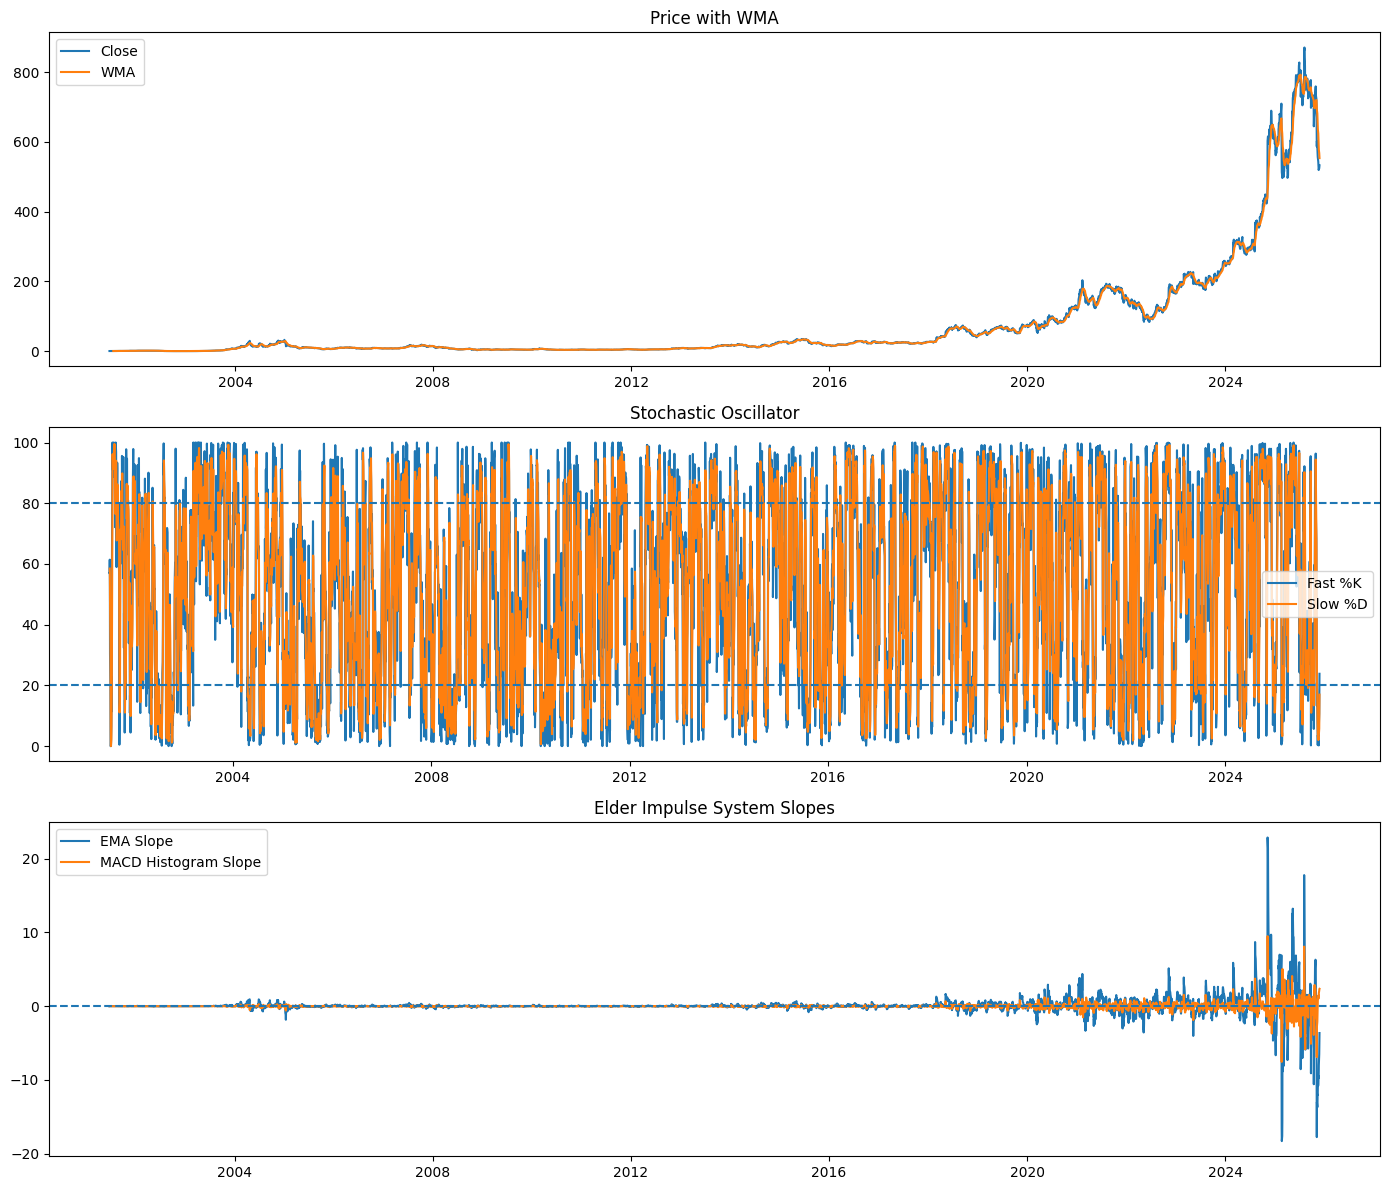

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "AXON"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------

STOCHASTIC_D_PERIOD = 3
STOCHASTIC_K_PERIOD = 14
STOCHASTIC_OVERBOUGHT = 80
STOCHASTIC_OVERSOLD = 20
WMA_PERIOD = 20
EIS_EMA_PERIOD = 13
EIS_MACD_FAST = 12
EIS_MACD_SLOW = 26
EIS_MACD_SIGNAL = 9

# -------------------------
# Indicator Functions
# -------------------------

def calculate_stochastic(df, k_period=STOCHASTIC_K_PERIOD, d_period=STOCHASTIC_D_PERIOD):
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()
    return df


def calculate_wma(df, period=WMA_PERIOD):
    weights = np.arange(1, period + 1)
    df['WMA'] = df['Close'].rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return df


def calculate_elder_impulse(df, ema_period=EIS_EMA_PERIOD, macd_fast=EIS_MACD_FAST,
                            macd_slow=EIS_MACD_SLOW, macd_signal=EIS_MACD_SIGNAL):
    ema = df['Close'].ewm(span=ema_period).mean()
    macd = df['Close'].ewm(span=macd_fast).mean() - df['Close'].ewm(span=macd_slow).mean()
    macd_signal_line = macd.ewm(span=macd_signal).mean()
    macd_hist = macd - macd_signal_line

    df['EMA_Slope'] = ema.diff()
    df['MACD_Hist_Slope'] = macd_hist.diff()
    return df


# -------------------------
# Calculate Indicators
# -------------------------

df = calculate_stochastic(df)
df = calculate_wma(df)
df = calculate_elder_impulse(df)

# -------------------------
# Plotting
# -------------------------

plt.figure(figsize=(14, 12))

# --- 1. Price + WMA ---
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['WMA'], label='WMA')
plt.title('Price with WMA')
plt.legend()

# --- 2. Stochastic ---
plt.subplot(3, 1, 2)
plt.plot(df.index, df['Fast_%K'], label='Fast %K')
plt.plot(df.index, df['Slow_%D'], label='Slow %D')
plt.axhline(80, linestyle='--')
plt.axhline(20, linestyle='--')
plt.title('Stochastic Oscillator')
plt.legend()

# --- 3. Elder Impulse Slopes ---
plt.subplot(3, 1, 3)
plt.plot(df.index, df['EMA_Slope'], label='EMA Slope')
plt.plot(df.index, df['MACD_Hist_Slope'], label='MACD Histogram Slope')
plt.axhline(0, linestyle='--')
plt.title('Elder Impulse System Slopes')
plt.legend()

plt.tight_layout()
plt.show()
